# PETR6397 Final Project: Oil Production Forecasting using Machine Learning

In [300]:
# Install required libraries

! pip install -q seaborn       # seaborn 
! pip install -q plotly        # plotly
! pip install -q matplotlib    # matplotlib
! pip install -q xgboost       # XGBoost
! pip install -q sklearn       # sklearn
! pip install -q scikit-learn  # scikit-learn:
! pip install -q statsmodels   # statsmodels
! pip install -q pmdarima      # pmdarima

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import r2_score, mean_squared_error
import warnings
warnings.filterwarnings("ignore")


ERROR: Invalid requirement: '#'
ERROR: Invalid requirement: '#'
ERROR: Invalid requirement: '#'
ERROR: Invalid requirement: '#'
ERROR: Invalid requirement: '#'
ERROR: Invalid requirement: '#'
ERROR: Invalid requirement: '#'
ERROR: Invalid requirement: '#'


## Part 1.  Exploratory Data Analysis

In [301]:
# Load the two data files from data folder into one dataframe df

# read the first CSV file into a DataFrame
df = pd.read_csv('Data/MonthlyProduction1.CSV')

# # read the second CSV file into another DataFrame
# df2 = pd.read_csv('Data/MonthlyProduction2.CSV')

# # concatenate the two DataFrames vertically
# df= pd.concat([df1, df2], axis=0)


# Visualize df
df.head(10)

,Entity ID,API/UWI,API/UWI List,Monthly Production Date,Monthly Oil,Monthly Gas,Monthly Water,Well Count,Days,Daily Avg Oil,Daily Avg Gas,Daily Avg Water,Reservoir,Well/Lease Name,Well Number,Operator Company Name,Production Type,Production Status,Entity Type,Producing Month Number
0,130854587,4.213540e+13,4213538451,12/1/19,1.0,139.0,7,1,NaN,0.03,4.48,0.23,CLEAR FORK,SCIMITAR,1,OCCIDENTAL PETROLEUM,OIL,ACTIVE,COM,1
1,130854587,4.213540e+13,4213538451,1/1/20,22.0,270.0,1205,1,NaN,0.71,8.71,38.87,CLEAR FORK,SCIMITAR,1,OCCIDENTAL PETROLEUM,OIL,ACTIVE,COM,2
2,130854587,4.213540e+13,4213538451,2/1/20,15.0,130.0,846,1,NaN,0.52,4.48,29.17,CLEAR FORK,SCIMITAR,1,OCCIDENTAL PETROLEUM,OIL,ACTIVE,COM,3
3,130854587,4.213540e+13,4213538451,3/1/20,14.0,308.0,788,1,NaN,0.45,9.94,25.42,CLEAR FORK,SCIMITAR,1,OCCIDENTAL PETROLEUM,OIL,ACTIVE,COM,4
4,130854587,4.213540e+13,4213538451,4/1/20,13.0,268.0,773,1,NaN,0.43,8.93,25.77,CLEAR FORK,SCIMITAR,1,OCCIDENTAL PETROLEUM,OIL,ACTIVE,COM,5
5,130854587,4.213540e+13,4213538451,5/1/20,9.0,31.0,546,1,NaN,0.29,1.00,17.61,CLEAR FORK,SCIMITAR,1,OCCIDENTAL PETROLEUM,OIL,ACTIVE,COM,6
6,130854587,4.213540e+13,4213538451,6/1/20,6.0,0.0,395,1,NaN,0.20,0.00,13.17,CLEAR FORK,SCIMITAR,1,OCCIDENTAL PETROLEUM,OIL,ACTIVE,COM,7
7,130854587,4.213540e+13,4213538451,7/1/20,6.0,244.0,435,1,NaN,0.19,7.87,14.03,CLEAR FORK,SCIMITAR,1,OCCIDENTAL PETROLEUM,OIL,ACTIVE,COM,8
8,130854587,4.213540e+13,4213538451,8/1/20,12.0,262.0,832,1,NaN,0.39,8.45,26.84,CLEAR FORK,SCIMITAR,1,OCCIDENTAL PETROLEUM,OIL,ACTIVE,COM,9
9,130854587,4.213540e+13,4213538451,9/1/20,10.0,188.0,698,1,NaN,0.33,6.27,23.27,CLEAR FORK,SCIMITAR,1,OCCIDENTAL PETROLEUM,OIL,ACTIVE,COM,10


In [302]:
# check the shape of the DataFrame

print("Shape of the DataFrame:", df.shape)

Shape of the DataFrame: (386648, 20)


In [303]:
# Data Profiling

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386648 entries, 0 to 386647
Data columns (total 20 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Entity ID                386648 non-null  int64  
 1   API/UWI                  386648 non-null  float64
 2   API/UWI List             386648 non-null  object 
 3   Monthly Production Date  386648 non-null  object 
 4   Monthly Oil              386458 non-null  float64
 5   Monthly Gas              386470 non-null  float64
 6   Monthly Water            386648 non-null  int64  
 7   Well Count               386648 non-null  int64  
 8   Days                     13502 non-null   float64
 9   Daily Avg Oil            386458 non-null  float64
 10  Daily Avg Gas            386470 non-null  float64
 11  Daily Avg Water          386648 non-null  float64
 12  Reservoir                385306 non-null  object 
 13  Well/Lease Name          386648 non-null  object 
 14  Well

In [304]:
# Checking Production type

production_types = df['Production Type'].unique()
print("Unique Production Types:", production_types)


Unique Production Types: ['OIL' 'GAS']


We have two types of Production in the datset. 

As we are focussed only into oil production; We will filter column 'Production Type' to 'Oil'

In [305]:
# Filter dataset for only for oil production type

df = df[df['Production Type'] == 'OIL']
df

,Entity ID,API/UWI,API/UWI List,Monthly Production Date,Monthly Oil,Monthly Gas,Monthly Water,Well Count,Days,Daily Avg Oil,Daily Avg Gas,Daily Avg Water,Reservoir,Well/Lease Name,Well Number,Operator Company Name,Production Type,Production Status,Entity Type,Producing Month Number
0,130854587,4.213540e+13,4213538451,12/1/19,1.0,139.0,7,1,NaN,0.03,4.48,0.23,CLEAR FORK,SCIMITAR,1,OCCIDENTAL PETROLEUM,OIL,ACTIVE,COM,1
1,130854587,4.213540e+13,4213538451,1/1/20,22.0,270.0,1205,1,NaN,0.71,8.71,38.87,CLEAR FORK,SCIMITAR,1,OCCIDENTAL PETROLEUM,OIL,ACTIVE,COM,2
2,130854587,4.213540e+13,4213538451,2/1/20,15.0,130.0,846,1,NaN,0.52,4.48,29.17,CLEAR FORK,SCIMITAR,1,OCCIDENTAL PETROLEUM,OIL,ACTIVE,COM,3
3,130854587,4.213540e+13,4213538451,3/1/20,14.0,308.0,788,1,NaN,0.45,9.94,25.42,CLEAR FORK,SCIMITAR,1,OCCIDENTAL PETROLEUM,OIL,ACTIVE,COM,4
4,130854587,4.213540e+13,4213538451,4/1/20,13.0,268.0,773,1,NaN,0.43,8.93,25.77,CLEAR FORK,SCIMITAR,1,OCCIDENTAL PETROLEUM,OIL,ACTIVE,COM,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
386643,127799434,4.213530e+13,4213533443,9/1/22,8.0,0.0,287,1,NaN,0.27,0.00,9.57,CLEAR FORK,GOLDSMITH-LANDRETH /DEEP/ UNIT,237,OCCIDENTAL PETROLEUM,OIL,ACTIVE,COM,497
386644,127799434,4.213530e+13,4213533443,10/1/22,7.0,0.0,240,1,NaN,0.23,0.00,7.74,CLEAR FORK,GOLDSMITH-LANDRETH /DEEP/ UNIT,237,OCCIDENTAL PETROLEUM,OIL,ACTIVE,COM,498
386645,127799434,4.213530e+13,4213533443,11/1/22,9.0,0.0,294,1,NaN,0.30,0.00,9.80,CLEAR FORK,GOLDSMITH-LANDRETH /DEEP/ UNIT,237,OCCIDENTAL PETROLEUM,OIL,ACTIVE,COM,499
386646,127799434,4.213530e+13,4213533443,12/1/22,9.0,0.0,298,1,NaN,0.29,0.00,9.61,CLEAR FORK,GOLDSMITH-LANDRETH /DEEP/ UNIT,237,OCCIDENTAL PETROLEUM,OIL,ACTIVE,COM,500


In [306]:
# check the shape of the DataFrame

print("Shape of the DataFrame:", df.shape)

Shape of the DataFrame: (385854, 20)


In [307]:
# print total well count in the dataset

well_count = df['Entity ID'].nunique()
print("Total number of unique oil producing wells:", well_count)

Total number of unique oil producing wells: 1046


In [308]:
# We can create a new column Gas to Oil Ratio (i.e GOR) which is important parameter in oil production

df['GOR'] = df['Monthly Gas'] / df['Monthly Oil']
df.head(10)

,Entity ID,API/UWI,API/UWI List,Monthly Production Date,Monthly Oil,Monthly Gas,Monthly Water,Well Count,Days,Daily Avg Oil,...,Daily Avg Water,Reservoir,Well/Lease Name,Well Number,Operator Company Name,Production Type,Production Status,Entity Type,Producing Month Number,GOR
0,130854587,4.213540e+13,4213538451,12/1/19,1.0,139.0,7,1,NaN,0.03,...,0.23,CLEAR FORK,SCIMITAR,1,OCCIDENTAL PETROLEUM,OIL,ACTIVE,COM,1,139.000000
1,130854587,4.213540e+13,4213538451,1/1/20,22.0,270.0,1205,1,NaN,0.71,...,38.87,CLEAR FORK,SCIMITAR,1,OCCIDENTAL PETROLEUM,OIL,ACTIVE,COM,2,12.272727
2,130854587,4.213540e+13,4213538451,2/1/20,15.0,130.0,846,1,NaN,0.52,...,29.17,CLEAR FORK,SCIMITAR,1,OCCIDENTAL PETROLEUM,OIL,ACTIVE,COM,3,8.666667
3,130854587,4.213540e+13,4213538451,3/1/20,14.0,308.0,788,1,NaN,0.45,...,25.42,CLEAR FORK,SCIMITAR,1,OCCIDENTAL PETROLEUM,OIL,ACTIVE,COM,4,22.000000
4,130854587,4.213540e+13,4213538451,4/1/20,13.0,268.0,773,1,NaN,0.43,...,25.77,CLEAR FORK,SCIMITAR,1,OCCIDENTAL PETROLEUM,OIL,ACTIVE,COM,5,20.615385
5,130854587,4.213540e+13,4213538451,5/1/20,9.0,31.0,546,1,NaN,0.29,...,17.61,CLEAR FORK,SCIMITAR,1,OCCIDENTAL PETROLEUM,OIL,ACTIVE,COM,6,3.444444
6,130854587,4.213540e+13,4213538451,6/1/20,6.0,0.0,395,1,NaN,0.20,...,13.17,CLEAR FORK,SCIMITAR,1,OCCIDENTAL PETROLEUM,OIL,ACTIVE,COM,7,0.000000
7,130854587,4.213540e+13,4213538451,7/1/20,6.0,244.0,435,1,NaN,0.19,...,14.03,CLEAR FORK,SCIMITAR,1,OCCIDENTAL PETROLEUM,OIL,ACTIVE,COM,8,40.666667
8,130854587,4.213540e+13,4213538451,8/1/20,12.0,262.0,832,1,NaN,0.39,...,26.84,CLEAR FORK,SCIMITAR,1,OCCIDENTAL PETROLEUM,OIL,ACTIVE,COM,9,21.833333
9,130854587,4.213540e+13,4213538451,9/1/20,10.0,188.0,698,1,NaN,0.33,...,23.27,CLEAR FORK,SCIMITAR,1,OCCIDENTAL PETROLEUM,OIL,ACTIVE,COM,10,18.800000


In [309]:
# Information about Data type 

df.dtypes

Entity ID                    int64
API/UWI                    float64
API/UWI List                object
Monthly Production Date     object
Monthly Oil                float64
Monthly Gas                float64
Monthly Water                int64
Well Count                   int64
Days                       float64
Daily Avg Oil              float64
Daily Avg Gas              float64
Daily Avg Water            float64
Reservoir                   object
Well/Lease Name             object
Well Number                 object
Operator Company Name       object
Production Type             object
Production Status           object
Entity Type                 object
Producing Month Number       int64
GOR                        float64
dtype: object

In [310]:
# summary statistics for numerical columns

df.describe()

,Entity ID,API/UWI,Monthly Oil,Monthly Gas,Monthly Water,Well Count,Days,Daily Avg Oil,Daily Avg Gas,Daily Avg Water,Producing Month Number,GOR
count,3.858540e+05,3.858540e+05,385854.000000,385676.000000,3.858540e+05,385854.000000,12900.0,385854.000000,385676.000000,385854.000000,385854.000000,3.855990e+05
mean,1.264904e+08,4.213525e+13,537.069617,503.662564,7.410641e+03,1.020899,0.0,17.644106,16.543608,243.457731,257.579139,inf
std,1.194819e+07,1.701271e+08,1103.490253,2571.976392,1.861663e+04,0.272107,0.0,36.237795,84.439632,611.548984,194.597442,NaN
min,4.748530e+05,4.213500e+13,0.000000,0.000000,0.000000e+00,1.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.000000e+00
25%,1.273339e+08,4.213510e+13,91.000000,15.000000,6.240000e+02,1.000000,0.0,3.000000,0.480000,20.550000,95.000000,6.544235e-02
50%,1.275302e+08,4.213530e+13,230.000000,67.000000,2.986000e+03,1.000000,0.0,7.570000,2.230000,98.100000,214.000000,2.777778e-01
75%,1.277265e+08,4.213540e+13,561.000000,280.000000,7.428000e+03,1.000000,0.0,18.420000,9.230000,243.740000,389.000000,1.059701e+00
max,1.310139e+08,4.213590e+13,35382.000000,190132.000000,1.411641e+06,9.000000,0.0,1141.350000,6133.290000,45536.810000,997.000000,inf


In [311]:
# check for any missing values

print("\n Number of missing values:")
df.isna().sum()


 Number of missing values:


Entity ID                       0
API/UWI                         0
API/UWI List                    0
Monthly Production Date         0
Monthly Oil                     0
Monthly Gas                   178
Monthly Water                   0
Well Count                      0
Days                       372954
Daily Avg Oil                   0
Daily Avg Gas                 178
Daily Avg Water                 0
Reservoir                    1342
Well/Lease Name                 0
Well Number                  3433
Operator Company Name           0
Production Type                 0
Production Status               0
Entity Type                     0
Producing Month Number          0
GOR                           255
dtype: int64

We observe that there are three common features to distinguish between wells, namely 'Entity ID', 'API/UWi', and 'API/UWI List,' all having the same significance in identifying a particular well. Therefore, any one of these features can be considered to uniquely identify a well. In this case, we are identifying a well with its unique 'Entity ID' and will drop the 'API/UWi' and 'API/UWI List' features.

Furthermore, the 'Days' and 'Well Number' columns have only 27,004 values out of a total of 773,296 rows, making imputation methods unsuitable for handling missing value issues, as they may introduce bias into the dataset. Therefore, to achieve better efficiency, we recommend dropping the 'Days' and 'Well Number' columns.

In [312]:
# drop the 'API/UWI','API/UWI List','Days','Well Number' columns

df = df.drop(columns=['API/UWI','API/UWI List','Days','Well Number'])
df.isna().sum()

Entity ID                     0
Monthly Production Date       0
Monthly Oil                   0
Monthly Gas                 178
Monthly Water                 0
Well Count                    0
Daily Avg Oil                 0
Daily Avg Gas               178
Daily Avg Water               0
Reservoir                  1342
Well/Lease Name               0
Operator Company Name         0
Production Type               0
Production Status             0
Entity Type                   0
Producing Month Number        0
GOR                         255
dtype: int64

Upon observing the data, we note a significant difference between the mean and median values for monthly oil production, where the mean is 536.23 and the median is 229. Therefore, replacing the missing values with the median of non-missing values is the optimal imputation method. This method is more robust to outliers than mean imputation and is suitable for skewed or outlier-containing data. Thus, we will impute the median values for 'Monthly Oil', 'Monthly Gas', 'Daily Avg Oil', 'Daily Avg Gas', and 'GOR'. Additionally, while computing the 'GOR' column, we encountered division errors resulting in 'inf' values, which can also be imputed using the median imputation method.

Finally, we will use mode imputation to impute the missing values in the categorical feature 'Reservoir' column.

In [313]:
# Imputation for missing values 

# A) impute missing values with median for numerical columns i.e. 'Monthly Oil', 'Monthly Gas', 'Daily Avg Oil', 'Daily Avg Gas'
num_cols = ['Monthly Oil', 'Monthly Gas', 'Daily Avg Oil', 'Daily Avg Gas','GOR']
for col in num_cols:
    median_val = df[col].median()
    df[col] = df[col].fillna(median_val)

# replace division error values in the GOR column with the median of the column
median_GOR = df['GOR'].replace([np.inf, -np.inf], np.nan).median()
df['GOR'] = df['GOR'].replace([np.inf, -np.inf], median_GOR)

# B) Now lets impute object feature 'Reservoir' with mode
df['Reservoir'].fillna(df['Reservoir'].mode()[0], inplace=True)

df.isna().sum()

Entity ID                  0
Monthly Production Date    0
Monthly Oil                0
Monthly Gas                0
Monthly Water              0
Well Count                 0
Daily Avg Oil              0
Daily Avg Gas              0
Daily Avg Water            0
Reservoir                  0
Well/Lease Name            0
Operator Company Name      0
Production Type            0
Production Status          0
Entity Type                0
Producing Month Number     0
GOR                        0
dtype: int64

In [314]:
# Analyzing other categorical feature
unique_operators = df['Operator Company Name'].unique()
unique_production_types = df['Production Type'].unique()
unique_entity_types = df['Entity Type'].unique()
unique_production_statuses = df['Production Status'].unique()

print("Unique Operator Company Name:", unique_operators)
print("Unique Production Type:", unique_production_types)
print("Unique Production Statuses:", unique_production_statuses)
print("Unique Entity Types:", unique_entity_types)


Unique Operator Company Name: ['OCCIDENTAL PETROLEUM']
Unique Production Type: ['OIL']
Unique Production Statuses: ['ACTIVE']
Unique Entity Types: ['COM' 'LEASE']


As observed above, the categorical features 'Operator Company Name', 'Production Type', and 'Production Status' have only one value, which does not offer much information. Therefore, it is recommended to drop the features 'Operator Company Name' and 'Production Status' from the dataset.

In [315]:
# drop the 'Operator Company Name','Production Type','Production Status' columns

df = df.drop(columns=['Operator Company Name','Production Type','Production Status'])
df.isna().sum()

Entity ID                  0
Monthly Production Date    0
Monthly Oil                0
Monthly Gas                0
Monthly Water              0
Well Count                 0
Daily Avg Oil              0
Daily Avg Gas              0
Daily Avg Water            0
Reservoir                  0
Well/Lease Name            0
Entity Type                0
Producing Month Number     0
GOR                        0
dtype: int64

In [316]:
# # Export the Cleaned data to a CSV file for Visualising with PowerBI

# p.to_csv('cleaned_dataset.csv', index=False)

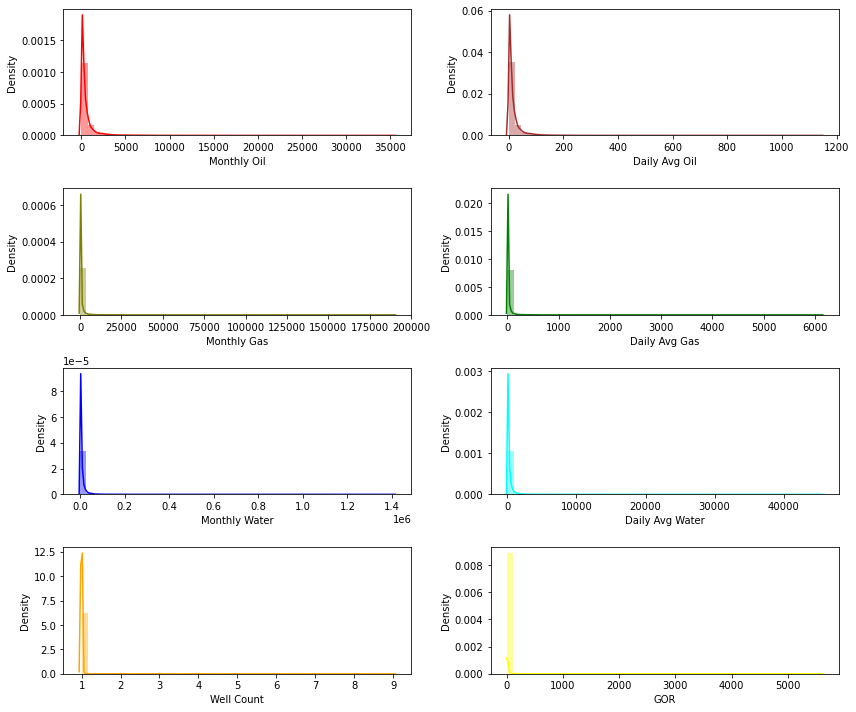

In [317]:
#let’s visualize the distribution of each parameter

f, axes = plt.subplots(4, 2, figsize=(12, 10))
sns.distplot(df['Monthly Oil'] , color="red", ax=axes[0, 0])
sns.distplot(df['Daily Avg Oil'] , color="brown", ax=axes[0, 1])
sns.distplot(df['Monthly Gas'] , color="olive", ax=axes[1, 0])
sns.distplot(df['Daily Avg Gas'] , color="green", ax=axes[1, 1])
sns.distplot(df['Monthly Water'] , color="blue", ax=axes[2, 0])
sns.distplot(df['Daily Avg Water'] , color="cyan", ax=axes[2, 1])
sns.distplot(df['Well Count'] , color="orange", ax=axes[3, 0])
sns.distplot(df['GOR'] , color="yellow", ax=axes[3, 1])

plt.tight_layout()

In [318]:
# # Checking any correlations between each other using a pairplot graph   (Note: Compuation time = approx 10 min)

# sns.pairplot(df)

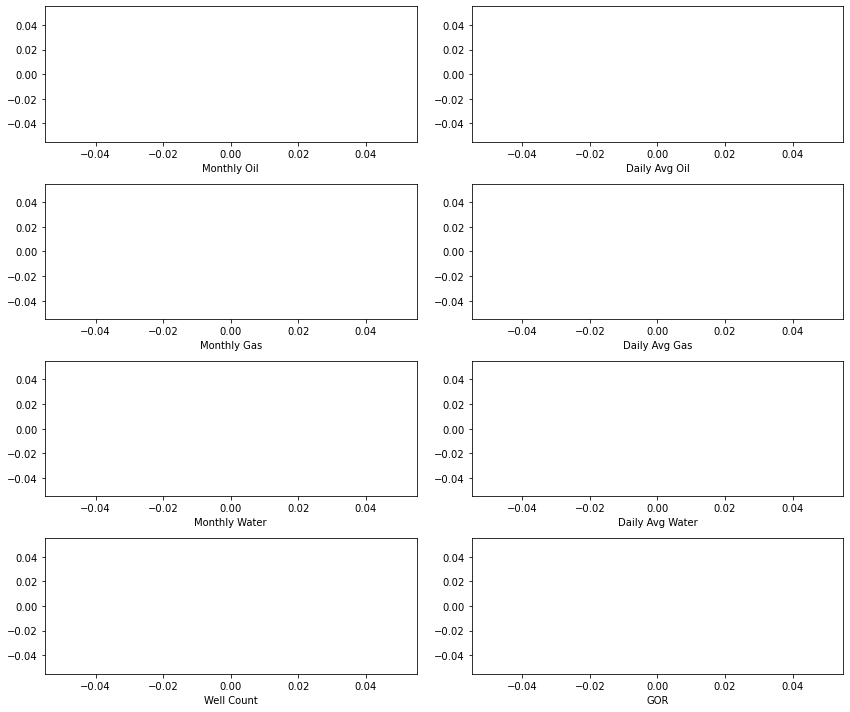

In [319]:
#let’s visualize the relations for each parameter

f, axes = plt.subplots(4, 2, figsize=(12, 10))
sns.scatterplot(df['Monthly Oil'] , color="red", ax=axes[0, 0])
sns.scatterplot(df['Daily Avg Oil'] , color="brown", ax=axes[0, 1])
sns.scatterplot(df['Monthly Gas'] , color="olive", ax=axes[1, 0])
sns.scatterplot(df['Daily Avg Gas'] , color="green", ax=axes[1, 1])
sns.scatterplot(df['Monthly Water'] , color="blue", ax=axes[2, 0])
sns.scatterplot(df['Daily Avg Water'] , color="cyan", ax=axes[2, 1])
sns.scatterplot(df['Well Count'] , color="orange", ax=axes[3, 0])
sns.scatterplot(df['GOR'] , color="yellow", ax=axes[3, 1])

plt.tight_layout()

<AxesSubplot:>

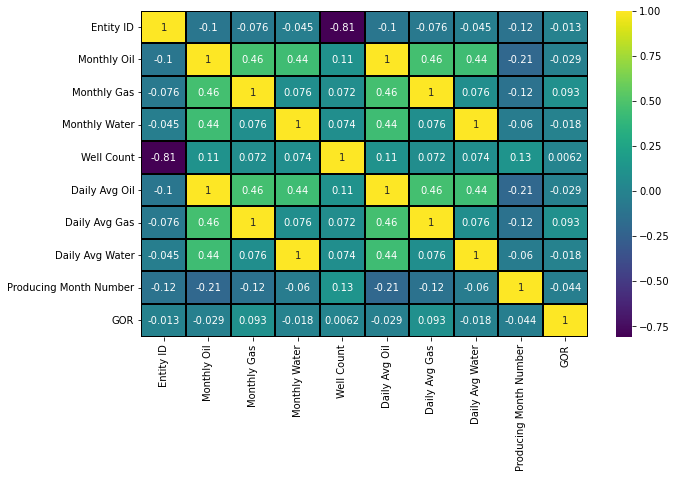

In [320]:
# Lets find any collinearity between input features using seaborn library

plt.figure(figsize=(10,6))
sns.heatmap(df.corr(),linewidths=2, linecolor='black',cmap='viridis', annot=True)

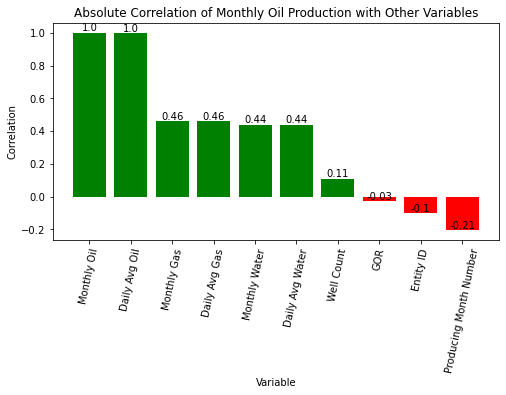

In [321]:
# calculate the correlation coefficients with the target variable
corr_matrix = df.corr(method='pearson')['Monthly Oil'].sort_values(ascending=False)

# Create a bar plot of the correlation matrix
fig, ax = plt.subplots(figsize=(8,4))
colors = np.where(corr_matrix.values > 0, 'g', 'r')
ax.bar(corr_matrix.index, corr_matrix.values, color=colors)

# Set the title and axis labels
ax.set_title('Absolute Correlation of Monthly Oil Production with Other Variables')
ax.set_xlabel('Variable')
ax.set_ylabel('Correlation')

# Rotate the x-axis labels for better visibility
plt.xticks(rotation=78)

# Annotate the correlation values on the bars
for i, v in enumerate(corr_matrix.values):
    ax.text(i, v + 0.01, str(round(v, 2)), ha='center')

# Show the plot
plt.show()

It is evident that 'Monthly Oil' production is strongly correlated with 'Daily Avg Oil'. Similarly, 'Monthly Water' and 'Monthly Gas' exhibit a high correlation with 'Daily Water' and 'Daily Gas'. As a result, to reduce the complexity of the model and avoid multicollinearity issues, it is generally recommended to remove one of the correlated features. 

Thus, while implementing the model, it is advisable to ignore these highly correlated features, namely 'Daily Avg Oil', 'Daily Water', and 'Daily Gas' to avoid multicollinearity issues.

## Part 2.  Implementing Machine Learning Models

### a. Data Transformation & Splitting it into Training, Validation & Test Dataset

In [322]:
# Load the dataset and create the features and target variable
X = df[['Entity ID','Monthly Gas','Monthly Water','Well Count','Producing Month Number','GOR']]
y = df['Monthly Oil']

from sklearn.preprocessing import StandardScaler

# create and fit into StandardScaler for X
scaler_X = StandardScaler().fit(X)

# transform features in X 
X_scaled = scaler_X.transform(X)

# create and fit into StandardScaler for y
scaler_y = StandardScaler().fit(y.to_numpy().reshape(-1, 1))

# transform target features y
y_scaled = scaler_y.transform(y.to_numpy().reshape(-1, 1))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Split the training set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

### b.  Multiple Model Implementation

In [323]:
# Implement & fit the models using GridsearchCV & Kfold cross validation

# Create K-fold cross validation for GridSearch calculations
cv = KFold(n_splits=5)

# 1. Linear Regression
lr_param_grid = {'fit_intercept': [True, False]}
lr = GridSearchCV(LinearRegression(),lr_param_grid,cv=cv).fit(X_train, y_train)

In [324]:
# 2. Ridge Regression
ridge_param_grid = {'alpha': [0.01, 0.1, 1.0, 10, 100]}
ridge = GridSearchCV(Ridge(random_state=42), ridge_param_grid, cv=cv).fit(X_train, y_train)

In [325]:
# 3. Lasso Regression
lasso_param_grid = {'alpha': [0.01, 0.1, 1.0, 10, 100]}
lasso = GridSearchCV(Lasso(random_state=42), lasso_param_grid, cv=cv).fit(X_train, y_train)

In [326]:
# 4. KNN                                     (Note: Compuation time = approx 5 min)
knn_param_grid = {
    'n_neighbors': [5, 10, 15],
    'weights': ['uniform', 'distance']}
knn = GridSearchCV(KNeighborsRegressor(), knn_param_grid, cv=cv).fit(X_train, y_train)

In [327]:
# 5. Decision Tree
tree_param_grid = {
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10]}
dtree = GridSearchCV(DecisionTreeRegressor(random_state=42), tree_param_grid, cv=cv).fit(X_train, y_train)

In [328]:
# 6. RandomForest                             (Note: Compuation time = approx 9-12 min)
rforest_param_grid = {
    'n_estimators': [10, 20, 30],
    'max_features': ['sqrt', 'log2']}
rforest = GridSearchCV(RandomForestRegressor(random_state=42),rforest_param_grid, cv=cv).fit(X_train, y_train)

In [329]:
# 7. XGBoost                                  (Note: Compuation time = approx 12-15 min)
xgb_param_grid = {
    'max_depth': [5, 10, 15],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [10, 20, 30]}
xgboost = GridSearchCV(xgb.XGBRegressor(random_state=42),xgb_param_grid, cv=cv).fit(X_train, y_train)

### c. Validating all the Model Evaluation on the Validation dataset

In [330]:
 # Evaluate the Best model from the validation set

models = [lr, ridge, lasso, knn, dtree, rforest, xgboost]
model_names = ['Linear Regression', 'Ridge', 'Lasso', 'KNN', 'Decision Tree','Random Forest', 'XGBoost']
best_models = []

print('Model Evaluation on Validation data')
for i, model in enumerate(models):
    y_val_pred = model.predict(X_val)
    r2 = r2_score(y_val, y_val_pred)
    mse = mean_squared_error(y_val, y_val_pred)
    print(f"\n{model_names[i]}:")
    print(f"R2 score: {r2}")
    print(f"RMSE: {np.sqrt(mse)}")

Model Evaluation on Validation data

Linear Regression:
R2 score: 0.351140433951062
RMSE: 0.7807159424804889

Ridge:
R2 score: 0.3511531345726612
RMSE: 0.7807083016697476

Lasso:
R2 score: 0.35122578792999193
RMSE: 0.7806645913043814

KNN:
R2 score: 0.8359604909096816
RMSE: 0.3925472348463523

Decision Tree:
R2 score: 0.9671759765124346
RMSE: 0.17559558788412516

Random Forest:
R2 score: 0.9806775549479557
RMSE: 0.13472516758505268

XGBoost:
R2 score: 0.9832987749042752
RMSE: 0.12525407288363785


### d. Final Model Performances comparison on the Testing dataset

In [331]:
 # Evaluate all the models on Testing data set

models = [lr, ridge, lasso, knn, dtree, rforest, xgboost]
model_names = ['Linear Regression', 'Ridge', 'Lasso', 'KNN', 'Decision Tree', 'Random Forest','XGBoost']
best_models = []
print('Final Model Evaluation on Test data')
for i, model in enumerate(models):
    y_test_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_test_pred)
    mse = mean_squared_error(y_test, y_test_pred)
    print(f"\n{model_names[i]}:")
    print(f"R2 score: {r2}")
    print(f"RMSE: {np.sqrt(mse)}")

Final Model Evaluation on Test data

Linear Regression:
R2 score: 0.39093616669223796
RMSE: 0.7845137706408382

Ridge:
R2 score: 0.39094959993939116
RMSE: 0.7845051191457821

Lasso:
R2 score: 0.390921234823965
RMSE: 0.7845233871899129

KNN:
R2 score: 0.814102353295053
RMSE: 0.4334171693798657

Decision Tree:
R2 score: 0.9629797503362306
RMSE: 0.1934144143614354

Random Forest:
R2 score: 0.9812229785090246
RMSE: 0.13774711672302026

XGBoost:
R2 score: 0.9768281109696032
RMSE: 0.1530205946891453


### e. Visualizing all the Model Predictions on Testing dataset

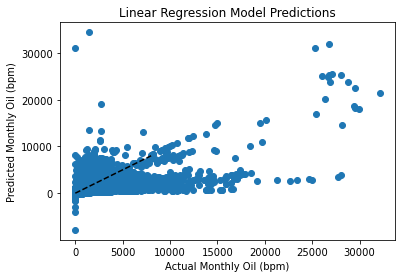

In [332]:
# Lets Inverse transform the scaled target variable to original target variables
y_test_org = scaler_y.inverse_transform(y_test.reshape(-1, 1))

# A) Linear Regression Model Predictions on Testing data set
y_pred_lr= lr.predict(X_test)

# Inverse transform the scaled predictions
y_pred_lr_org = scaler_y.inverse_transform(y_pred_lr.reshape(-1, 1))

# Create a scatter plot of actual vs predicted values
plt.scatter(y_test_org, y_pred_lr_org)
plt.plot([0, 8000], [0, 8000], '--k')
plt.xlabel("Actual Monthly Oil (bpm)")
plt.ylabel("Predicted Monthly Oil (bpm)")
plt.title("Linear Regression Model Predictions")
plt.show()

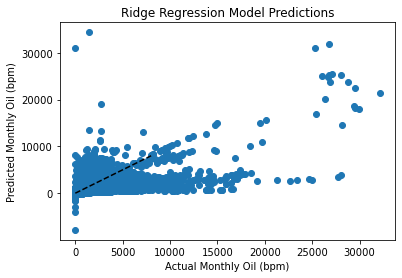

In [333]:
# B) Ridge Regression Model Predictions on Testing data set
y_pred_ridge = ridge.predict(X_test)

# Inverse transform the scaled predictions
y_pred_ridge_org = scaler_y.inverse_transform(y_pred_ridge.reshape(-1, 1))

# Create a scatter plot of actual vs predicted values
plt.scatter(y_test_org, y_pred_ridge_org)
plt.plot([0, 8000], [0, 8000], '--k')
plt.xlabel("Actual Monthly Oil (bpm)")
plt.ylabel("Predicted Monthly Oil (bpm)")
plt.title("Ridge Regression Model Predictions")
plt.show()

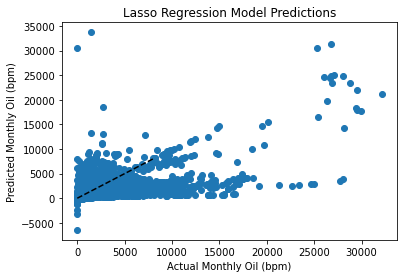

In [334]:
# C) Lasso Regression Model Predictions on Testing data set
y_pred_lasso = lasso.predict(X_test)

# Inverse transform the scaled predictions
y_pred_lasso_org = scaler_y.inverse_transform(y_pred_lasso.reshape(-1, 1))

# Create a scatter plot of actual vs predicted values
plt.scatter(y_test_org, y_pred_lasso_org)
plt.plot([0, 8000], [0, 8000], '--k')
plt.xlabel("Actual Monthly Oil (bpm)")
plt.ylabel("Predicted Monthly Oil (bpm)")
plt.title("Lasso Regression Model Predictions")
plt.show()

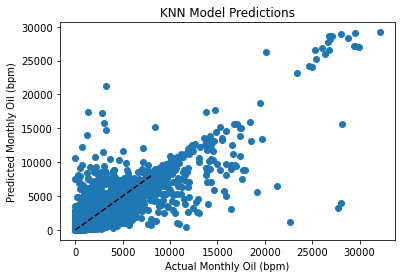

In [335]:
# D) KNN Model Predictions on VTesting data set
y_pred_knn = knn.predict(X_test)

# Inverse transform the scaled predictions
y_pred_knn_org = scaler_y.inverse_transform(y_pred_knn.reshape(-1, 1))

# Create a scatter plot of actual vs predicted values
plt.scatter(y_test_org, y_pred_knn_org)
plt.plot([0, 8000], [0, 8000], '--k')
plt.xlabel("Actual Monthly Oil (bpm)")
plt.ylabel("Predicted Monthly Oil (bpm)")
plt.title("KNN Model Predictions")
plt.show()

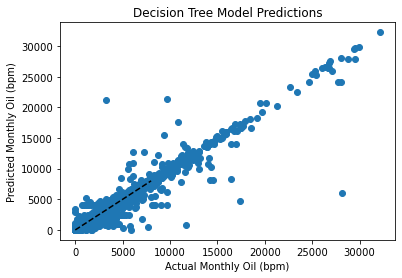

In [336]:
# E) Decision Tree Model Predictions on Testing data set
y_pred_dtree = dtree.predict(X_test)

# Inverse transform the scaled predictions
y_pred_dtree_org = scaler_y.inverse_transform(y_pred_dtree.reshape(-1, 1))

# Create a scatter plot of actual vs predicted values
plt.scatter(y_test_org, y_pred_dtree_org)
plt.plot([0, 8000], [0, 8000], '--k')
plt.xlabel("Actual Monthly Oil (bpm)")
plt.ylabel("Predicted Monthly Oil (bpm)")
plt.title("Decision Tree Model Predictions")
plt.show()

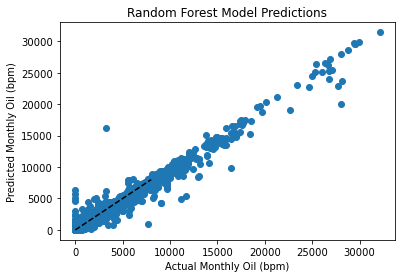

In [337]:
# F) Random Forest Model Predictions on Testing data set
y_pred_rforest = rforest.predict(X_test)

# Inverse transform the scaled predictions
y_pred_rforest_org = scaler_y.inverse_transform(y_pred_rforest.reshape(-1, 1))

# Create a scatter plot of actual vs predicted values
plt.scatter(y_test_org, y_pred_rforest_org)
plt.plot([0, 8000], [0, 8000], '--k')
plt.xlabel("Actual Monthly Oil (bpm)")
plt.ylabel("Predicted Monthly Oil (bpm)")
plt.title("Random Forest Model Predictions")
plt.show()

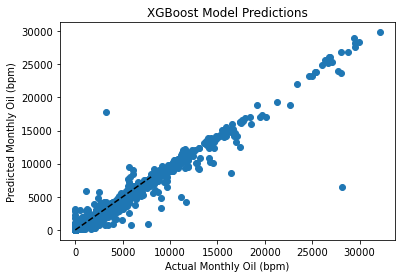

In [338]:
# G) XGBoost Model Predictions on Testing data set
y_pred_xgb = xgboost.predict(X_test)

# Inverse transform the scaled predictions
y_pred_xgb_org = scaler_y.inverse_transform(y_pred_xgb.reshape(-1, 1))

# Create a scatter plot of actual vs predicted values
plt.scatter(y_test_org, y_pred_xgb_org)
plt.plot([0, 8000], [0, 8000], '--k')
plt.xlabel("Actual Monthly Oil (bpm)")
plt.ylabel("Predicted Monthly Oil (bpm)")
plt.title("XGBoost Model Predictions")
plt.show()

We have seen that Random Forest is been performing best in both the Validation and Testing dataset, based on model evaluation like R2 being highest (i.e. 0.99 to 0.98) & RMSE being the lowest of all other models (i.e. 0.08 to 0.10) . 

---Summary---

a) Validation results for Random Forest:-

    R2 score: 0.991

    RMSE: 0.095

b) Testing results for Random Forest:-

    R2 score: 0.989

    RMSE: 0.104

Thus, we can select "Random Forest" for our given problem in oil production forecasting. 

## Part 3. Forecasting Estimated Ultimate Recovery (EUR) using ARIMA model

In [339]:
print(df['Entity ID'].unique())

[130854587 130831615 130751622 ... 127820554 127820411 127799434]


In [340]:
unique_wells = df['Entity ID'].unique()


In [341]:
unique_wells[0:80]

array([130854587, 130831615, 130751622, 130204826, 130157156, 130094870,
       130029586, 130029585, 129869598, 129720697, 129645700, 129604914,
       129566730, 129032549, 129018412, 129018408, 129018396, 128921475,
       128906514, 128891587, 128891572, 128807013, 128806952, 128806898,
       128806886, 128776703, 128776679, 128739066, 128739065, 128739063,
       128739062, 128739007, 128739006, 128739000, 128738750, 128738708,
       128737968, 128675439, 128675435, 128675431, 128675356, 128673745,
       128659068, 128658882, 128658880, 128658877, 128658364, 128658357,
       128658355, 128658348, 128658344, 128658338, 128658337, 128658330,
       128658327, 128658307, 128658293, 128658290, 128658258, 128658257,
       128658252, 128658251, 128658250, 128658244, 128658232, 128658231,
       128658214, 128658213, 128658204, 128658203, 128658188, 128640136,
       128640071, 128640038, 128640020, 128639926, 128639824, 128638455,
       128638454, 128638453], dtype=int64)

In [342]:
# ARIMA Model for Estimated Ultimate Recovery (EUR)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA


# # Preprocess the data
# # df['Entity ID'] = pd.to_datetime(df['Monthly Production Date'])
# df.set_index('Well/Lease Name', inplace=True)
# df['Cumulative Oil'] = df['Monthly Oil'].cumsum()

df5 = df[df['Entity ID'] == 128658344]
print(df5)

      Entity ID Monthly Production Date  Monthly Oil  Monthly Gas  \
5490  128658344                  1/1/84        935.0         26.0   
5491  128658344                  2/1/84        726.0          0.0   
5492  128658344                  3/1/84        788.0          0.0   
5493  128658344                  4/1/84        759.0          0.0   
5494  128658344                  5/1/84        818.0         28.0   
...         ...                     ...          ...          ...   
5954  128658344                  9/1/22         56.0        154.0   
5955  128658344                 10/1/22         52.0        132.0   
5956  128658344                 11/1/22         62.0        148.0   
5957  128658344                 12/1/22         63.0        150.0   
5958  128658344                  1/1/23         15.0         52.0   

      Monthly Water  Well Count  Daily Avg Oil  Daily Avg Gas  \
5490          17147           1          30.16           0.84   
5491          13605           1          

In [343]:
df5['Monthly Production Date'] = pd.to_datetime(df5['Monthly Production Date'])
df5.set_index('Monthly Production Date', inplace=True)

In [344]:
monthly_oil_1 = df5['Monthly Oil']
monthly_oil_1

Monthly Production Date
1984-01-01    935.0
1984-02-01    726.0
1984-03-01    788.0
1984-04-01    759.0
1984-05-01    818.0
              ...  
2022-09-01     56.0
2022-10-01     52.0
2022-11-01     62.0
2022-12-01     63.0
2023-01-01     15.0
Name: Monthly Oil, Length: 469, dtype: float64

Text(0.5, 1.0, 'Decline Curve')

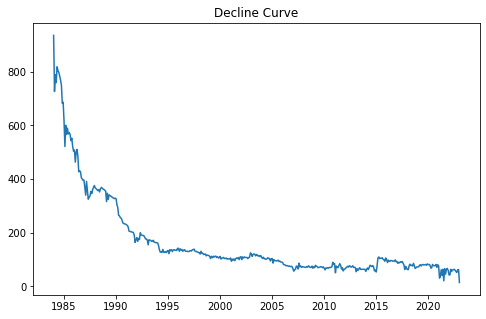

In [345]:
plt.figure(figsize=(8,5))
plt.plot(monthly_oil_1)
plt.title('Decline Curve')

In [346]:
import warnings
from statsmodels.tsa.arima.model import ARIMA
from itertools import product

# ignore warnings
warnings.filterwarnings('ignore')

# define the range for p, d, and q
p = range(0, 3)
d = range(0, 2)
q = range(0, 3)

# create a list of all possible (p, d, q) tuples
pdq = list(product(p, d, q))

# evaluate ARIMA model with each (p, d, q) tuple
results = []
for param in pdq:
    try:
        model_arima = ARIMA(monthly_oil_1, order=param)
        model_arima_fit = model_arima.fit()
        results.append((param, model_arima_fit.aic))
    except:
        continue

# find the (p, d, q) tuple with the lowest AIC value
best_pdq = min(results, key=lambda x: x[1])[0]

# fit ARIMA model with the best (p, d, q) tuple
model_arima = ARIMA(monthly_oil_1, order=best_pdq)
model_arima_fit = model_arima.fit()

# make ARIMA forecast
arima_forecast = model_arima_fit.forecast(steps=1)

# print forecasts and best (p, d, q) tuple
print("Best (p, d, q) tuple:", best_pdq)

Best (p, d, q) tuple: (2, 1, 1)


In [347]:
predictions = model_arima.fit().predict()

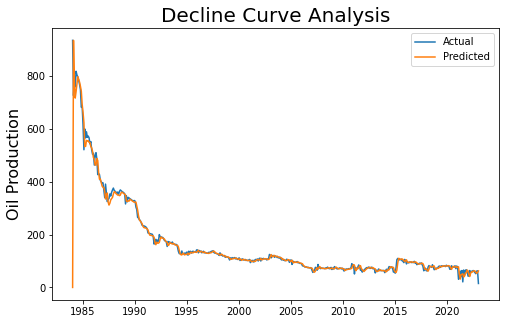

In [348]:
plt.figure(figsize=(8,5))
plt.plot(monthly_oil_1, label="Actual")
plt.plot(predictions, label="Predicted")
plt.title('Decline Curve Analysis', fontsize=20)
plt.ylabel('Oil Production', fontsize=16)
plt.legend()

In [349]:
forecast_values = model_arima_fit.forecast(steps=30)
forecast_values

2023-02-01    36.024169
2023-03-01    23.882454
2023-04-01    27.683164
2023-05-01    23.826865
2023-06-01    23.654462
2023-07-01    21.715975
2023-08-01    20.630431
2023-09-01    19.139224
2023-10-01    17.847180
2023-11-01    16.463636
2023-12-01    15.128263
2024-01-01    13.773932
2024-02-01    12.432894
2024-03-01    11.089642
2024-04-01     9.751619
2024-05-01     8.415239
2024-06-01     7.082218
2024-07-01     5.751721
2024-08-01     4.424142
2024-09-01     3.099282
2024-10-01     1.777228
2024-11-01     0.457930
2024-12-01    -0.858596
2025-01-01    -2.172367
2025-02-01    -3.483383
2025-03-01    -4.791654
2025-04-01    -6.097182
2025-05-01    -7.399975
2025-06-01    -8.700038
2025-07-01    -9.997377
Freq: MS, Name: predicted_mean, dtype: float64

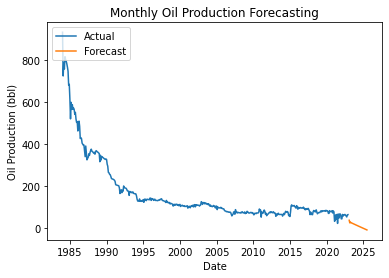

In [350]:
# Plot actual and forecasted values
plt.plot(monthly_oil_1[-500:-1], label='Actual')
plt.plot(forecast_values, label='Forecast')
plt.legend(loc='upper left')
plt.title('Monthly Oil Production Forecasting')
plt.xlabel('Date')
plt.ylabel('Oil Production (bbl)')
plt.show()

In [351]:
df7 = df[df['Entity ID'] == 127168831]
df7


,Entity ID,Monthly Production Date,Monthly Oil,Monthly Gas,Monthly Water,Well Count,Daily Avg Oil,Daily Avg Gas,Daily Avg Water,Reservoir,Well/Lease Name,Entity Type,Producing Month Number,GOR
371474,127168831,10/1/78,274.0,73.0,5842,1,8.84,2.35,188.45,GRAYBURG,"WITCHER, J. E.",COM,1,0.266423
371475,127168831,11/1/78,325.0,0.0,6972,1,10.83,0.00,232.40,GRAYBURG,"WITCHER, J. E.",COM,2,0.000000
371476,127168831,12/1/78,308.0,120.0,6654,1,9.94,3.87,214.65,GRAYBURG,"WITCHER, J. E.",COM,3,0.389610
371477,127168831,1/1/79,357.0,167.0,6101,1,11.52,5.39,196.81,GRAYBURG,"WITCHER, J. E.",COM,4,0.467787
371478,127168831,2/1/79,415.0,151.0,5849,1,14.82,5.39,208.89,GRAYBURG,"WITCHER, J. E.",COM,5,0.363855
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
372001,127168831,9/1/22,57.0,16.0,572,1,1.90,0.53,19.07,GRAYBURG,"WITCHER, J. E.",COM,528,0.280702
372002,127168831,10/1/22,59.0,14.0,590,1,1.90,0.45,19.03,GRAYBURG,"WITCHER, J. E.",COM,529,0.237288
372003,127168831,11/1/22,57.0,16.0,574,1,1.90,0.53,19.13,GRAYBURG,"WITCHER, J. E.",COM,530,0.280702
372004,127168831,12/1/22,48.0,14.0,477,1,1.55,0.45,15.39,GRAYBURG,"WITCHER, J. E.",COM,531,0.291667


In [352]:
df7['Monthly Production Date'] = pd.to_datetime(df7['Monthly Production Date'])
df7.set_index('Monthly Production Date', inplace=True)

Text(0.5, 1.0, 'Decline Curve')

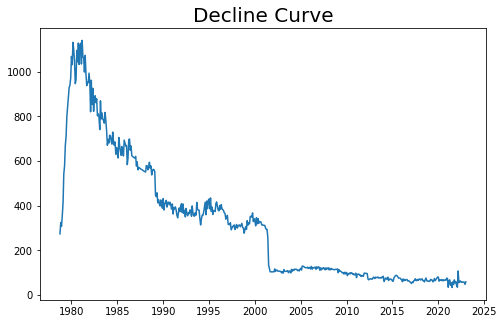

In [353]:
monthly_oil_3 = df7['Monthly Oil']
plt.figure(figsize=(8,5))
plt.plot(monthly_oil_3)
plt.title("Decline Curve", fontsize=20)

In [354]:
monthly_oil_3

Monthly Production Date
1978-10-01    274.0
1978-11-01    325.0
1978-12-01    308.0
1979-01-01    357.0
1979-02-01    415.0
              ...  
2022-09-01     57.0
2022-10-01     59.0
2022-11-01     57.0
2022-12-01     48.0
2023-01-01     59.0
Name: Monthly Oil, Length: 532, dtype: float64

In [355]:
# define the range for p, d, and q
p = range(0, 3)
d = range(0, 2)
q = range(0, 3)

# create a list of all possible (p, d, q) tuples
pdq = list(product(p, d, q))

# evaluate ARIMA model with each (p, d, q) tuple
results = []
for param in pdq:
    try:
        model_arima = ARIMA(monthly_oil_3, order=param)
        model_arima_fit = model_arima.fit()
        results.append((param, model_arima_fit.aic))
    except:
        continue

# find the (p, d, q) tuple with the lowest AIC value
best_pdq = min(results, key=lambda x: x[1])[0]

# fit ARIMA model with the best (p, d, q) tuple
model_arima = ARIMA(monthly_oil_3, order=best_pdq)
model_arima_fit = model_arima.fit()

# make ARIMA forecast
arima_forecast = model_arima_fit.forecast(steps=1)

# print forecasts and best (p, d, q) tuple
print("Best (p, d, q) tuple:", best_pdq)
# print("ARIMA Forecast:", arima_forecast[0])

Best (p, d, q) tuple: (2, 1, 1)


In [356]:
predictions = model_arima.fit().predict()

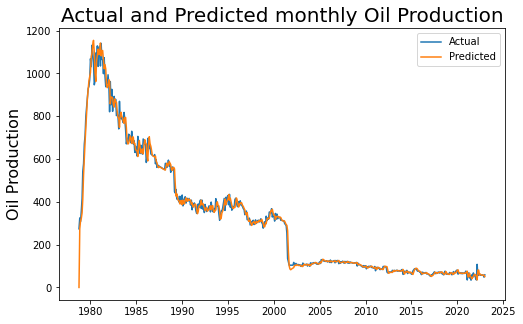

In [357]:
plt.figure(figsize=(8,5))
plt.plot(monthly_oil_3, label="Actual")
plt.plot(predictions, label="Predicted")
plt.title('Actual and Predicted monthly Oil Production', fontsize=20)
plt.ylabel('Oil Production', fontsize=16)
plt.legend()

In [358]:
forecast_values = model_arima_fit.forecast(30)
forecast_values

2023-02-01    53.803716
2023-03-01    55.772032
2023-04-01    54.588711
2023-05-01    54.808777
2023-06-01    54.420374
2023-07-01    54.311486
2023-08-01    54.089592
2023-09-01    53.927635
2023-10-01    53.748874
2023-11-01    53.586837
2023-12-01    53.426372
2024-01-01    53.273837
2024-02-01    53.126104
2024-03-01    52.984246
2024-04-01    52.847492
2024-05-01    52.715897
2024-06-01    52.589160
2024-07-01    52.467148
2024-08-01    52.349666
2024-09-01    52.236553
2024-10-01    52.127644
2024-11-01    52.022784
2024-12-01    51.921821
2025-01-01    51.824611
2025-02-01    51.731015
2025-03-01    51.640898
2025-04-01    51.554131
2025-05-01    51.470589
2025-06-01    51.390153
2025-07-01    51.312707
Freq: MS, Name: predicted_mean, dtype: float64

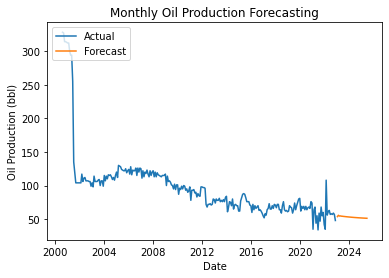

In [359]:
# Plot actual and forecasted values
plt.plot(monthly_oil_3[-270:-1], label='Actual')
plt.plot(forecast_values, label='Forecast')
plt.legend(loc='upper left')
plt.title('Monthly Oil Production Forecasting')
plt.xlabel('Date')
plt.ylabel('Oil Production (bbl)')
plt.show()

In [360]:
# group by entity id and count the number of rows for each group
grouped_df = df.groupby('Entity ID').size().reset_index(name='count')

# filter the groups with count greater than 400
filtered_df = grouped_df[grouped_df['count'] > 400]

# print the filtered dataframe
print(filtered_df.head(20))

    Entity ID  count
0      474853    888
1      474870    826
2      475095    849
3      475107    870
4   127168547    541
5   127168569    829
6   127168797    458
7   127168815    428
8   127168831    532
15  127168910    672
16  127178942    865
17  127178981    718
18  127179173    496
19  127179184    459
20  127179206    419
25  127179274    544
26  127179275    718
27  127189161    686
28  127189229    739
29  127189246    560


In [361]:
df8 = df[df['Entity ID'] == 127179274]
df8

,Entity ID,Monthly Production Date,Monthly Oil,Monthly Gas,Monthly Water,Well Count,Daily Avg Oil,Daily Avg Gas,Daily Avg Water,Reservoir,Well/Lease Name,Entity Type,Producing Month Number,GOR
364666,127179274,10/1/77,324.0,241.0,2891,1,10.45,7.77,93.26,AMHY,SOUTH FOSTER UNIT,COM,1,0.743827
364667,127179274,11/1/77,216.0,0.0,1789,1,7.20,0.00,59.63,AMHY,SOUTH FOSTER UNIT,COM,2,0.000000
364668,127179274,12/1/77,288.0,311.0,1744,1,9.29,10.03,56.26,AMHY,SOUTH FOSTER UNIT,COM,3,1.079861
364669,127179274,1/1/78,360.0,299.0,1702,1,11.61,9.65,54.90,AMHY,SOUTH FOSTER UNIT,COM,4,0.830556
364670,127179274,2/1/78,408.0,237.0,1600,1,14.57,8.46,57.14,AMHY,SOUTH FOSTER UNIT,COM,5,0.580882
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
365205,127179274,9/1/22,6.0,19.0,161,1,0.20,0.63,5.37,AMHY,SOUTH FOSTER UNIT,COM,540,3.166667
365206,127179274,10/1/22,6.0,16.0,154,1,0.19,0.52,4.97,AMHY,SOUTH FOSTER UNIT,COM,541,2.666667
365207,127179274,11/1/22,5.0,17.0,128,1,0.17,0.57,4.27,AMHY,SOUTH FOSTER UNIT,COM,542,3.400000
365208,127179274,12/1/22,5.0,14.0,127,1,0.16,0.45,4.10,AMHY,SOUTH FOSTER UNIT,COM,543,2.800000


In [362]:
df8['Monthly Production Date'] = pd.to_datetime(df8['Monthly Production Date'])
df8.set_index('Monthly Production Date', inplace=True)
monthly_oil_4 = df8['Monthly Oil']

Text(0.5, 1.0, 'Decline Curve')

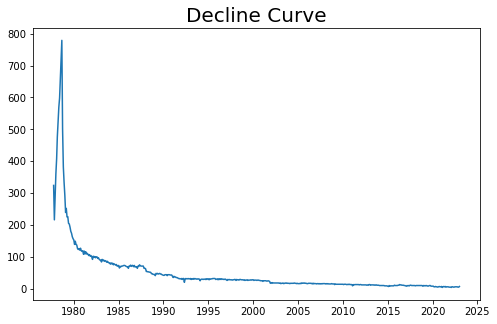

In [363]:

plt.figure(figsize=(8,5))
plt.plot(monthly_oil_4)
plt.title("Decline Curve", fontsize=20)


In [364]:
# define the range for p, d, and q
p = range(0, 3)
d = range(0, 2)
q = range(0, 3)

# create a list of all possible (p, d, q) tuples
pdq = list(product(p, d, q))

# evaluate ARIMA model with each (p, d, q) tuple
results = []
for param in pdq:
    try:
        model_arima = ARIMA(monthly_oil_4, order=param)
        model_arima_fit = model_arima.fit()
        results.append((param, model_arima_fit.aic))
    except:
        continue

# find the (p, d, q) tuple with the lowest AIC value
best_pdq = min(results, key=lambda x: x[1])[0]

# fit ARIMA model with the best (p, d, q) tuple
model_arima = ARIMA(monthly_oil_4, order=best_pdq)
model_arima_fit = model_arima.fit()

# make ARIMA forecast
arima_forecast = model_arima_fit.forecast(steps=1)

# print forecasts and best (p, d, q) tuple
print("Best (p, d, q) tuple:", best_pdq)
# print("ARIMA Forecast:", arima_forecast[0])

Best (p, d, q) tuple: (2, 1, 2)


In [365]:
model_arima = ARIMA(monthly_oil_4, order=(1,1,1))
model_arima_fit = model_arima.fit()
predictions = model_arima.fit().predict()

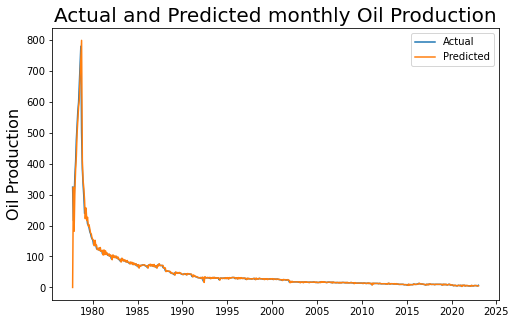

In [366]:
plt.figure(figsize=(8,5))
plt.plot(monthly_oil_4, label="Actual")
plt.plot(predictions, label="Predicted")
plt.title('Actual and Predicted monthly Oil Production', fontsize=20)
plt.ylabel('Oil Production', fontsize=16)
plt.legend()


In [367]:
forecast_values = model_arima_fit.forecast(70)
forecast_values


2023-02-01    7.643260
2023-03-01    7.831151
2023-04-01    7.886033
2023-05-01    7.902063
2023-06-01    7.906746
                ...   
2028-07-01    7.908678
2028-08-01    7.908678
2028-09-01    7.908678
2028-10-01    7.908678
2028-11-01    7.908678
Freq: MS, Name: predicted_mean, Length: 70, dtype: float64

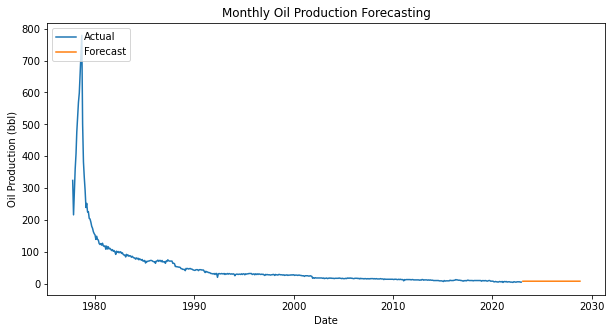

In [368]:
# Plot actual and forecasted values
plt.figure(figsize=(10,5))
plt.plot(monthly_oil_4[-550:-1], label='Actual')
plt.plot(forecast_values, label='Forecast')
plt.legend(loc='upper left')
plt.title('Monthly Oil Production Forecasting')
plt.xlabel('Date')
plt.ylabel('Oil Production (bbl)')
plt.show()

## Conclusion: